## Họ và tên: Nguyễn Mạnh Niên
## Mã sinh viên: 20226019541

In [1]:
# Cài đặt các thư viện cần thiết
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # Loại bỏ các cảnh báo
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [2]:
# Khai báo các giá trị tham số cố định
PATH_FILE       = '/kaggle/input/data-tx2/data_tx2.csv' # Đường dẫn đến file dữ liệu
K_FOLD          = 3                 # Dùng trong đánh giá kiểm định chéo
DPI             = 200               # Độ phân giải cho biểu đồ

### a. Đọc dữ liệu từ tệp cho trước và thực hiện phép chuẩn hóa theo phương pháp min-max

In [3]:
# Đọc dữ liệu sử dụng pandas
try:
    # Đọc file CSV
    df = pd.read_csv(PATH_FILE,
                     header = 0, 
                     sep = ',',
                     skipinitialspace = True)
    print('Đọc file thành công!')
    print(df.head(5))   # In ra 5 dòng đầu tiên
except FileNotFoundError:
    print(f"Lỗi: File '{PATH_FILE}' không tồn tại.")
except Exception:
    print(f"Lỗi {Exception}.")

Đọc file thành công!
     A     B    C    D    E     F    G Class
0  9.0  15.0  3.7  2.9  1.2   5.9  4.0     P
1  3.5   4.5  3.1  2.5  2.8  10.0  6.7     N
2  4.1   4.9  2.1  3.7  2.5  10.0  3.3     P
3  4.6   3.5  2.5  2.2  2.7  11.0  7.2     P
4  5.6   1.6  4.1  3.9  4.7   5.6  2.9     N


In [4]:
# Kiểm tra xem dữ liệu có bị thiếu hay không
check_nan = df.isna().any().any()
if check_nan == True:
    print("Dữ liệu bị thiếu!")
else:
    print("Dữ liệu đầy đủ!")

Dữ liệu đầy đủ!


In [5]:
# Chuyển đổi các thuộc tính dạng ký tự sang số
Le = LabelEncoder()
df['Class'] = Le.fit_transform(df['Class'])

In [6]:
# Chuẩn hóa Min-Max
# Lấy dữ liệu chuẩn hóa từ DataFrame
df_X = df.iloc[:, :-1]
df_y = df.iloc[:, -1]

# Chuẩn hóa dữ liệu
scaler  = MinMaxScaler()
df_X    = scaler.fit_transform(df_X)

In [7]:
# Hiển thị dữ liệu đã chuẩn hóa
X = pd.DataFrame(df_X, columns=df.columns[: -1])
print(X)

           A         B     C         D      E         F         G
0   1.000000  1.000000  0.80  0.062500  0.000  0.372093  0.304348
1   0.191176  0.216418  0.50  0.026786  0.400  0.848837  0.891304
2   0.279412  0.246269  0.00  0.133929  0.325  0.848837  0.152174
3   0.352941  0.141791  0.20  0.000000  0.375  0.965116  1.000000
4   0.500000  0.000000  1.00  0.151786  0.875  0.337209  0.065217
5   0.514706  0.171642  0.25  0.321429  0.275  0.220930  0.217391
6   0.985294  0.067164  0.15  0.116071  0.100  0.790698  0.043478
7   0.102941  0.119403  0.40  0.151786  0.675  0.918605  0.304348
8   0.000000  0.044776  0.90  1.000000  0.250  1.000000  0.065217
9   0.602941  0.186567  0.15  0.883929  0.150  0.000000  0.304348
10  0.014706  0.111940  0.70  0.000000  1.000  0.360465  0.086957
11  0.823529  0.082090  0.65  0.044643  0.975  0.081395  0.000000


### b. Chuẩn bị dữ liệu cho quá trình thực hiện sử dụng phương pháp K-Fold với k = 3

In [8]:
# Câu b: Chuẩn bị dữ liệu theo phương pháp kiểm định chéo k-folds
data_fold = {               # chứa dữ liệu của từng fold
    'X_train':[],           # Chứa X_train của từng fold
    'y_train' : [],         # Chứa y_train của từng fold
    'X_test' : [],          # Chứa X_test của từng fold
    'y_test' : []           # Chứa y_test của từng fold
}  

# Khởi tạo k fold
kf = KFold(n_splits = K_FOLD)
# Chia dữ liệu theo từng fold
for train_index, test_index in kf.split(df_X):
    data_fold['X_train'].append(df_X[train_index])
    data_fold['X_test'].append(df_X[test_index])
    data_fold['y_train'].append(df_y[train_index])
    data_fold['y_test'].append(df_y[test_index])


### c. Xây dựng mô hình Naive-bayes

In [9]:
# Khởi tạo dict chứa các chỉ số đánh giá của mô hình
parameters_bayes = {
    'accuracy' : [],
    'recall' : [],
    'precision' : [],
    'f1-score' : [],
    'execution-time' : []
}

In [10]:
for i in range(K_FOLD):
    # Khởi tạo mô hình Naive-bayes
    clf_bayes = GaussianNB()

    start_bayes = time.time()       # Bắt đầu ghi thời gian huấn luyện
    # Huấn luyện mô hình
    clf_bayes.fit(data_fold['X_train'][i], data_fold['y_train'][i])
    execution_time_bayes = time.time() - start_bayes       # Kết thúc thời gian huấn luyện
    
    # Dự đoán kết quả
    y_pred_bayes = clf_bayes.predict(data_fold['X_test'][i])

    # Tính các chỉ số đánh giá mô hình
    acc = accuracy_score(data_fold['y_test'][i], y_pred_bayes)
    rec = recall_score(data_fold['y_test'][i], y_pred_bayes)
    f1 = f1_score(data_fold['y_test'][i], y_pred_bayes)
    pre = precision_score(data_fold['y_test'][i], y_pred_bayes)

    # Lưu kết quả vào mảng
    parameters_bayes['accuracy'].append(acc)
    parameters_bayes['recall'].append(rec)
    parameters_bayes['precision'].append(pre)
    parameters_bayes['f1-score'].append(f1)
    parameters_bayes['execution-time'].append(execution_time_bayes)

    # In ra kết quả theo từng Fold
    print("FOLD:", i + 1)  # In số thứ tự của fold
    # Các chỉ số đánh giá
    print("{:<15}{:<15}{:<15}{:<15}{:<15}".format("Precision", "Recall", "F1-Score", "Accuracy", 'Execution Time'))
    # In kết quả
    print("{:<15}{:<15}{:<15}{:<15}{:<15}".format(
        f"{pre * 100:.4}" + '%', f"{rec * 100:.4}" + '%', f"{f1 * 100:.4}" + "%", f"{acc * 100:.4}" + '%', f"{execution_time_bayes:.4}" + 's'
    ))
    print('-' * 80)

FOLD: 1
Precision      Recall         F1-Score       Accuracy       Execution Time 
75.0%          100.0%         85.71%         75.0%          0.001079s      
--------------------------------------------------------------------------------
FOLD: 2
Precision      Recall         F1-Score       Accuracy       Execution Time 
66.67%         66.67%         66.67%         50.0%          0.001323s      
--------------------------------------------------------------------------------
FOLD: 3
Precision      Recall         F1-Score       Accuracy       Execution Time 
50.0%          50.0%          50.0%          50.0%          0.001508s      
--------------------------------------------------------------------------------


In [11]:
# Tính trung bình các chỉ số
acc_bayes = np.mean(parameters_bayes['accuracy'])
rec_bayes = np.mean(parameters_bayes['recall'])
pre_bayes = np.mean(parameters_bayes['precision'])
f1_bayes = np.mean(parameters_bayes['f1-score'])
execution_bayes = np.mean(parameters_bayes['execution-time'])

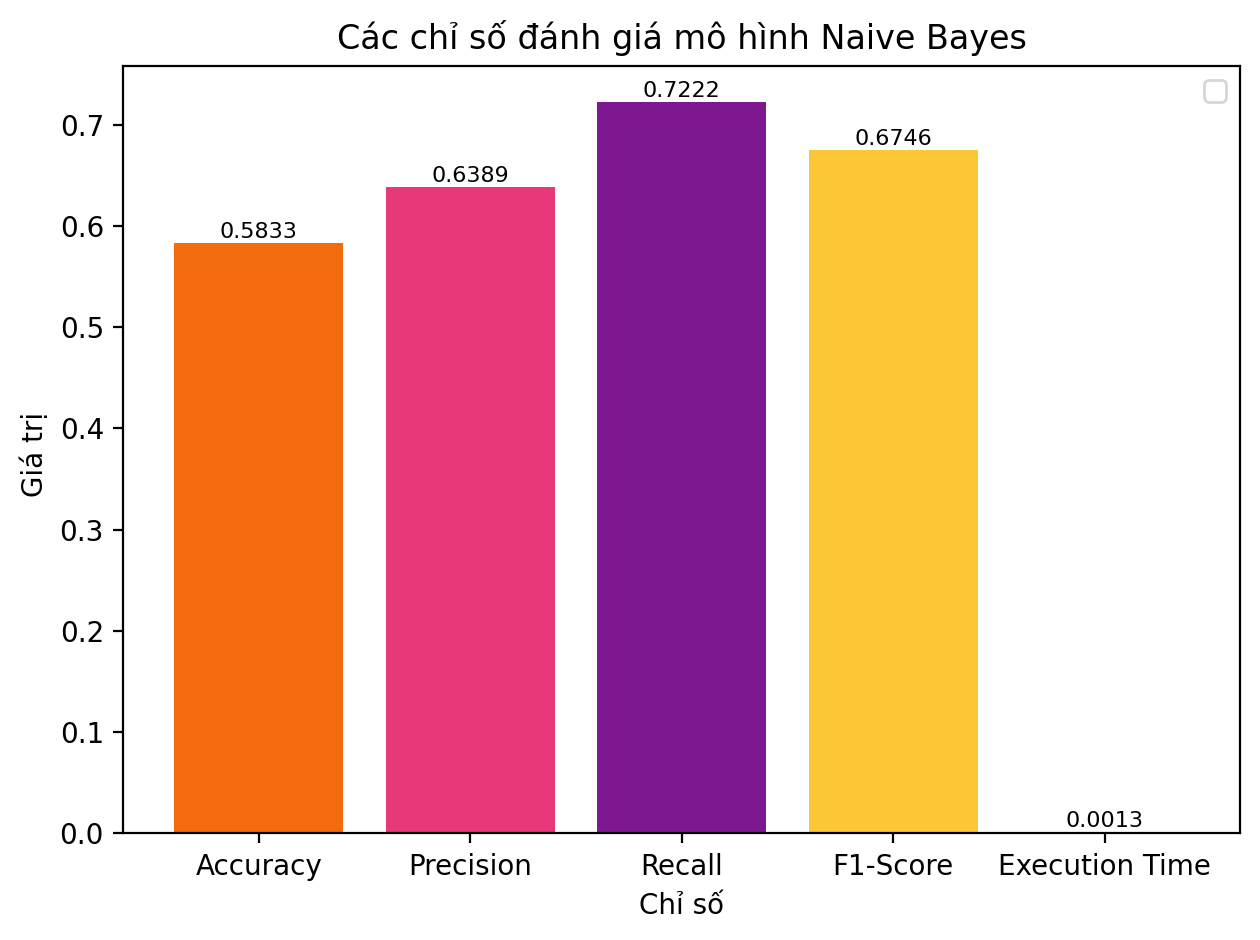

In [12]:
# Vẽ biểu đồ thể hiện các chỉ số
label_name = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Execution Time']

values = [acc_bayes, pre_bayes, rec_bayes, f1_bayes, execution_bayes]
colors = ['#F26B0F', '#E73879', '#7E1891', '#FCC737', '#131010']
fig, ax = plt.subplots(dpi = DPI)
rec = ax.bar(label_name, values, color = colors)
# Thêm tiêu đề cho biểu đồ
ax.set_ylabel('Giá trị ')
ax.set_xlabel('Chỉ số')
ax.set_title('Các chỉ số đánh giá mô hình Naive Bayes')
ax.set_xticks(np.arange(len(label_name)))
ax.legend()
for rect in rec:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.001, f'{height:.4f}', ha='center', va='bottom', fontsize=8)

fig.tight_layout()
plt.show()

### d. Sử dụng mô hình SVM

In [13]:
# Khởi tạo dict chứa các chỉ số đánh giá của mô hình
parameters_svm = {
    'accuracy' : [],
    'recall' : [],
    'precision' : [],
    'f1-score' : [],
    'execution-time' : []
}

In [14]:
for i in range(K_FOLD):
    clf_svm = SVC()         # Khởi tạo mô hình SVM
    start_svm = time.time() # Bắt đầu tính giờ
    # Huấn luyện mô hình
    clf_svm.fit(data_fold['X_train'][i], data_fold['y_train'][i])
    execution_time_svm = time.time() - start_svm      # Kết thúc thời gian huấn luyện

    
    # Dự đoán kết quả
    y_pred_svm = clf_svm.predict(data_fold['X_test'][i])

    # Tính các chỉ số đánh giá của mô hình
    acc = accuracy_score(data_fold['y_test'][i], y_pred_svm)
    rec = recall_score(data_fold['y_test'][i], y_pred_svm)
    f1 = f1_score(data_fold['y_test'][i], y_pred_svm)
    pre = precision_score(data_fold['y_test'][i], y_pred_svm)

    # Lưu kết quả
    parameters_svm['accuracy'].append(acc)
    parameters_svm['recall'].append(rec)
    parameters_svm['precision'].append(pre)
    parameters_svm['f1-score'].append(f1)
    parameters_svm['execution-time'].append(execution_time_svm)

    # In ra kết quả theo từng Fold
    print("FOLD:", i + 1)  # In số thứ tự của fold
    # Các chỉ số đánh giá
    print("{:<15}{:<15}{:<15}{:<15}{:<15}".format("Precision", "Recall", "F1-Score", "Accuracy", 'Execution Time'))
    # In kết quả
    print("{:<15}{:<15}{:<15}{:<15}{:<15}".format(
        f"{pre * 100:.4}" + '%', f"{rec * 100:.4}" + '%', f"{f1 * 100:.4}" + "%", f"{acc * 100:.4}" + '%', f"{execution_time_bayes:.4}" + 's'
    ))
    print('-' * 80)

# Tính giá trị trung bình của các chỉ số
acc_svm = np.mean(parameters_svm['accuracy'])
rec_svm = np.mean(parameters_svm['recall'])
pre_svm = np.mean(parameters_svm['precision'])
f1_svm = np.mean(parameters_svm['f1-score'])
execution_svm = np.mean(parameters_svm['execution-time'])

FOLD: 1
Precision      Recall         F1-Score       Accuracy       Execution Time 
75.0%          100.0%         85.71%         75.0%          0.001508s      
--------------------------------------------------------------------------------
FOLD: 2
Precision      Recall         F1-Score       Accuracy       Execution Time 
75.0%          100.0%         85.71%         75.0%          0.001508s      
--------------------------------------------------------------------------------
FOLD: 3
Precision      Recall         F1-Score       Accuracy       Execution Time 
50.0%          100.0%         66.67%         50.0%          0.001508s      
--------------------------------------------------------------------------------


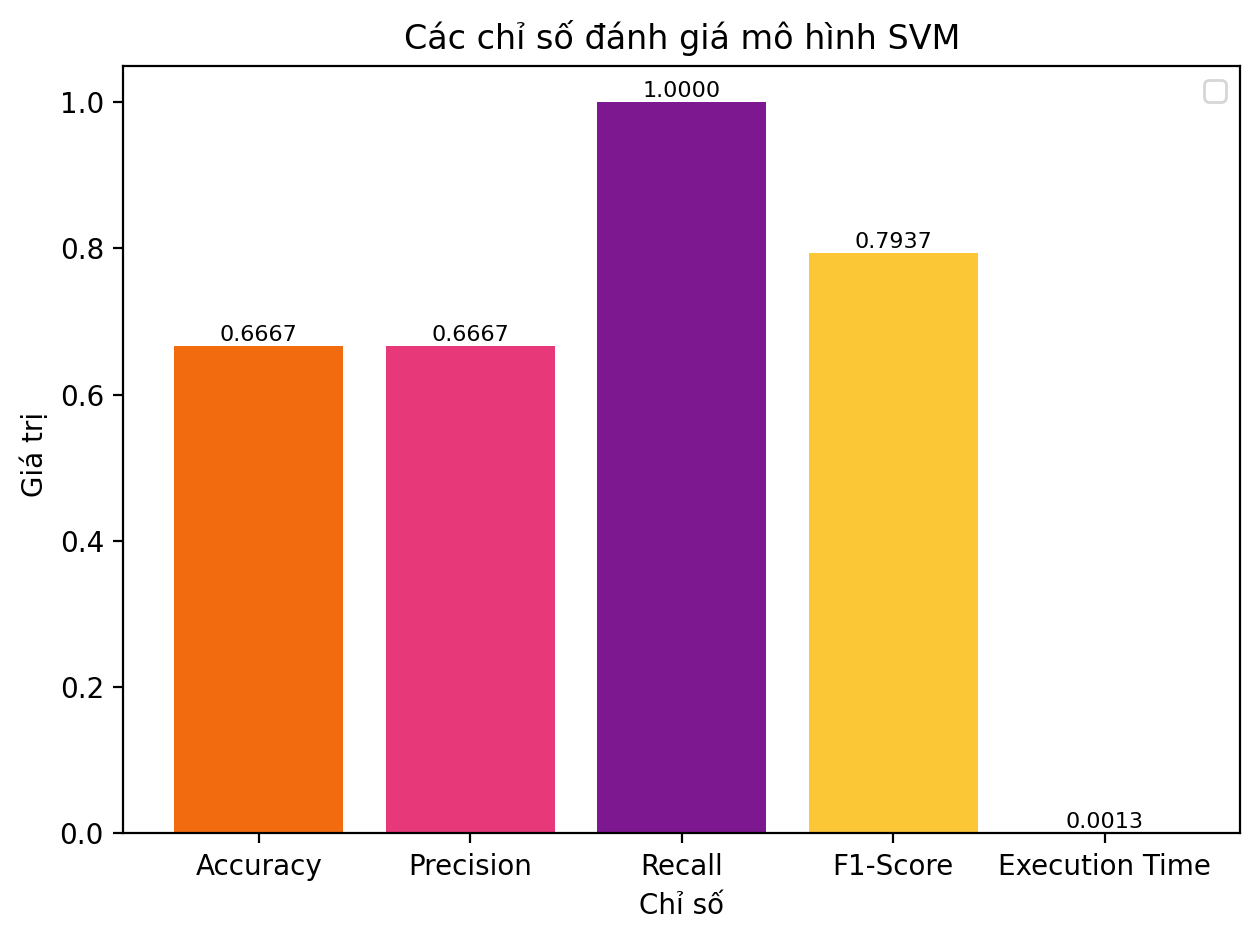

In [15]:
# Vẽ biểu đồ đánh giá các chỉ số
label_name = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Execution Time']

values = [acc_svm, pre_svm, rec_svm, f1_svm, execution_svm]
colors = ['#F26B0F', '#E73879', '#7E1891', '#FCC737', '#131010']
fig, ax = plt.subplots(dpi = DPI)
rec = ax.bar(label_name, values, color = colors)
# Thêm tiêu đề cho biểu đồ
ax.set_ylabel('Giá trị ')
ax.set_xlabel('Chỉ số')
ax.set_title('Các chỉ số đánh giá mô hình SVM')
ax.set_xticks(np.arange(len(label_name)))
ax.legend()
for rect in rec:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.001, f'{height:.4f}', ha='center', va='bottom', fontsize=8)

fig.tight_layout()
plt.show()